Extract mel-spectrogram from audio

In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import LeaveOneOut
import os
import PIL.Image as Image
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt


Find graphic specs

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transforms:
            image = self.transforms(image)
        label = torch.tensor(label) # Convert label to tensor here
        return image, label

# Define a function to load images
def load_data(dir_path):
    X = []
    y = []
    labels = ['PD', 'HC']
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img = Image.open(os.path.join(path, img)).convert('RGB')
                X.append(img)
                y.append(class_num)
            except Exception as e:
                print(e)
    return X, y

In [3]:
# Load the data
X, y = load_data('./plots/')
# Convert labels to tensor
y = torch.tensor(y)

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # resize images to match VGG input size
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization values for ImageNet
])

# Create a dataset
dataset = CustomDataset(X, y, transforms=data_transforms)

# Define the Leave-One-Out cross validator
loo = LeaveOneOut()

train

In [4]:
# Initialize the model
model = models.vgg11(pretrained=True)

# Modify the last layer to match the number of classes
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)

# If you have a GPU, move the model to GPU
if torch.cuda.is_available():
    model = model.cuda()

# To store metrics
train_acc = []
train_loss = []
val_acc = []
val_loss = []
train_prec = []
train_recall = []
val_prec = []
val_recall = []

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
fold = 1

# LOO Cross Validation model evaluation
for train_index, test_index in loo.split(dataset):

    # Select samples for current fold
    print("Fold: ", fold)
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    # Loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    fold = fold +1 
    # Train the model
    for epoch in range(10):
        correct_train = 0
        total_train = 0
        loss_train = 0
        preds_train = []
        trues_train = []
        for inputs, labels in train_loader:
            # If you have a GPU, move the data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            # Compute loss
            loss = criterion(outputs, labels)

            # Update train statistics
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_acc.append(correct_train / total_train)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc.append(correct_train / total_train)
        train_loss.append(loss_train / len(train_loader)) 
        train_prec.append(precision_score(trues_train, preds_train, average='macro'))
        train_recall.append(recall_score(trues_train, preds_train, average='macro'))
        # Evaluate the model
        model.eval()
        correct_val = 0
        total_val = 0
        loss_val = 0
        preds_val = []
        trues_val = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                # If you have a GPU, move the data to GPU
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # Forward pass
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                # Compute loss
                loss = criterion(outputs, labels)
                loss_val += loss.item()
                
                # Update validation statistics
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # Store predictions and true labels for precision and recall
                preds_val += predicted.tolist()
                trues_val += labels.tolist()
                
            val_acc.append(correct_val / total_val)
            val_loss.append(loss_val / len(test_loader))
            val_prec.append(precision_score(trues_val, preds_val, average='macro'))
            val_recall.append(recall_score(trues_val, preds_val, average='macro'))


        print(f'Epoch {epoch+1}, Train Accuracy: {correct_train / total_train}, Validation Accuracy: {correct_val / total_val}')

C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold:  1


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.52, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.5, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.46, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 7, Train Accuracy: 0.54, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 8, Train Accuracy: 0.48, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.46, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 10, Train Accuracy: 0.54, Validation Accuracy: 0.0
Fold:  2


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.42, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.5, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.5, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.5, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.56, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 10, Train Accuracy: 0.58, Validation Accuracy: 0.0
Fold:  3


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 1, Train Accuracy: 0.5, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.48, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.62, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 7, Train Accuracy: 0.64, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.64, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.64, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.64, Validation Accuracy: 1.0
Fold:  4


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.74, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 2, Train Accuracy: 0.78, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 3, Train Accuracy: 0.7, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 4, Train Accuracy: 0.52, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.38, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 7, Train Accuracy: 0.58, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.48, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.54, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.5, Validation Accuracy: 1.0
Fold:  5


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 1, Train Accuracy: 0.54, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 2, Train Accuracy: 0.62, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.7, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 4, Train Accuracy: 0.72, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.72, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.7, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 7, Train Accuracy: 0.86, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.82, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.88, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.8, Validation Accuracy: 1.0
Fold:  6


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 1, Train Accuracy: 0.88, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 2, Train Accuracy: 0.86, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 3, Train Accuracy: 0.78, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 4, Train Accuracy: 0.74, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 5, Train Accuracy: 0.88, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 6, Train Accuracy: 0.94, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 7, Train Accuracy: 0.9, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 8, Train Accuracy: 0.94, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 9, Train Accuracy: 0.92, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 10, Train Accuracy: 0.96, Validation Accuracy: 0.0
Fold:  7


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.88, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.9, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 8, Train Accuracy: 0.68, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.56, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.66, Validation Accuracy: 1.0
Fold:  8


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.7, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.8, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 8, Train Accuracy: 0.9, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 9, Train Accuracy: 0.86, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 10, Train Accuracy: 0.86, Validation Accuracy: 0.0
Fold:  9


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 1, Train Accuracy: 0.88, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 2, Train Accuracy: 0.64, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.74, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.8, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.9, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.98, Validation Accuracy: 1.0
Fold:  10


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples

Epoch 1, Train Accuracy: 0.8, Validation Accuracy: 0.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.68, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.9, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.9, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.98, Validation Accuracy: 1.0
Fold:  11


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  12


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.86, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.86, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.98, Validation Accuracy: 1.0
Fold:  13


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.94, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.88, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.86, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.9, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 0.98, Validation Accuracy: 1.0
Fold:  14


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 0.98, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 0.96, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 0.92, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  15


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  16


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  17


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  18


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  19


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  20


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  21


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  22


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  23


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  24


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  25


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  26


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  27


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  28


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  29


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  30


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  31


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  32


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  33


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  34


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  35


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  36


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  37


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  38


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  39


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  40


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  41


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  42


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  43


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  44


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  45


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  46


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  47


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  48


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  49


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  50


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0
Fold:  51


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 1, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 2, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 3, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 4, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 5, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 6, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 7, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 8, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here
C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


Epoch 9, Train Accuracy: 1.0, Validation Accuracy: 1.0
Epoch 10, Train Accuracy: 1.0, Validation Accuracy: 1.0


C:\Users\datng\AppData\Local\Temp\ipykernel_19528\4171091995.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label) # Convert label to tensor here


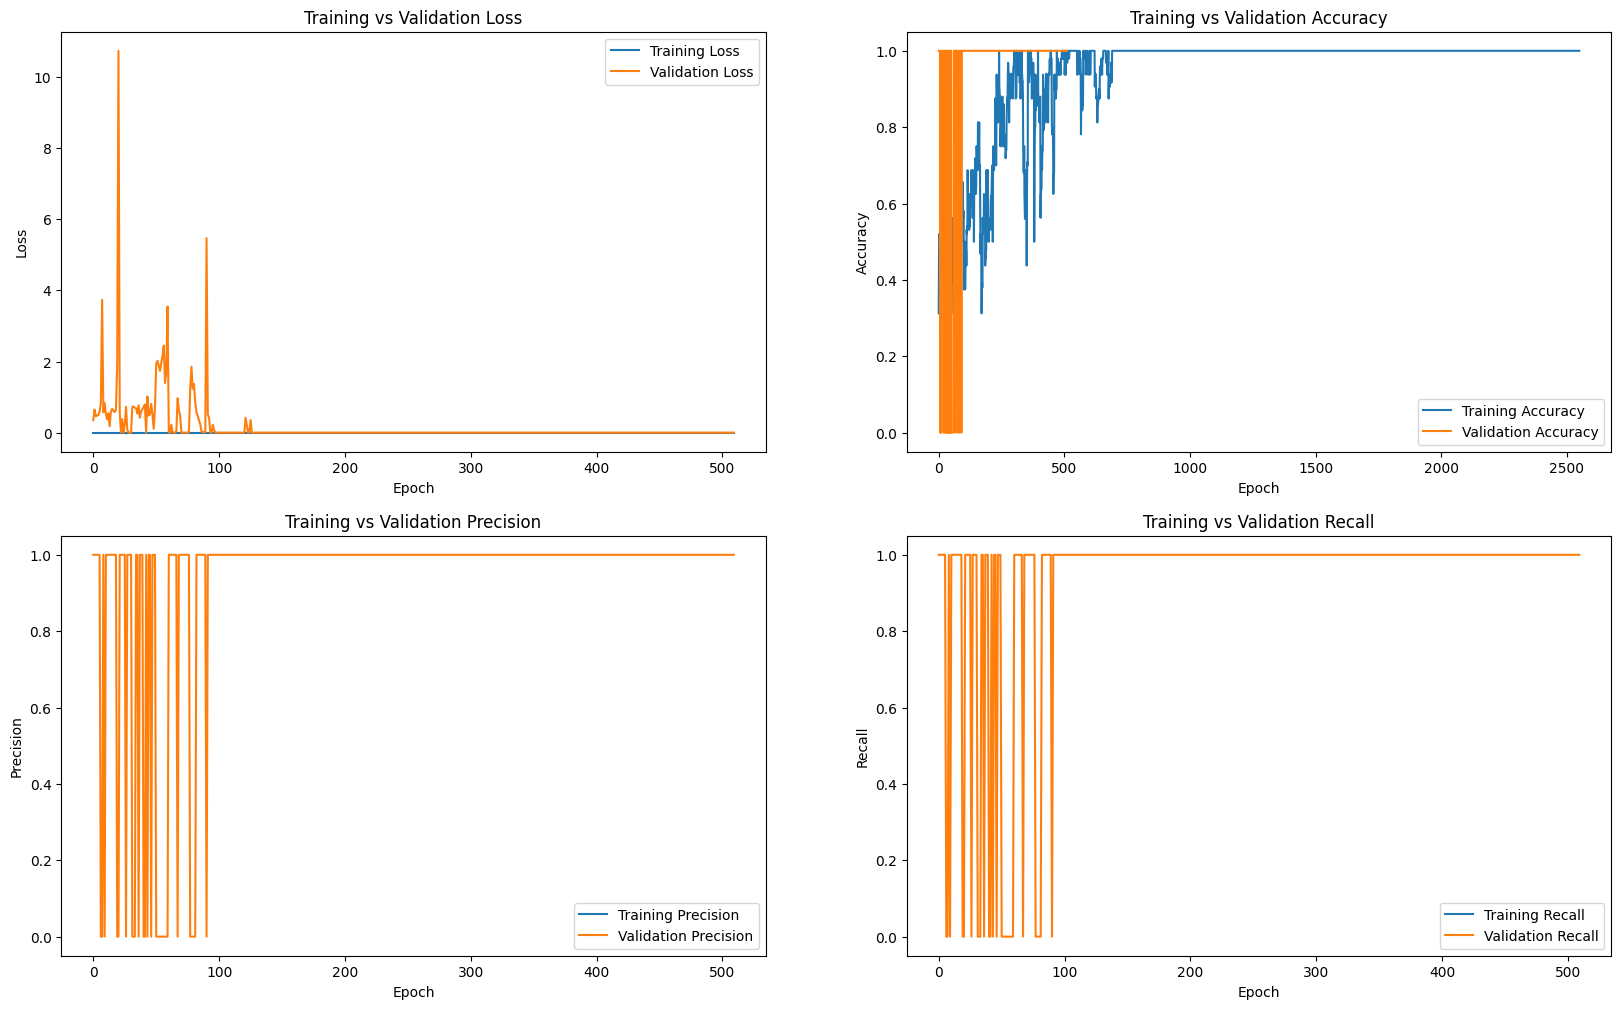

In [5]:
# Plotting
plt.figure(figsize=(20, 12))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(train_prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.title('Training vs Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(train_recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training vs Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.show()